# Secret Pre-Landscape Notebook MERSCOPE

In [1]:
%load_ext autoreload
%autoreload 2
%env ANYWIDGET_HMR=1

env: ANYWIDGET_HMR=1


In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from skimage.io import imread
import os
import zarr
import celldega as dega
from matplotlib.colors import to_hex
print(dega.pre.__file__)


technology = 'MERSCOPE'

/Users/whuan/opt/anaconda3/envs/celldega_env/lib/python3.9/site-packages/anywidget/_util.py:261: UserWarning: anywidget: Live-reloading feature is disabled. To enable, please install the 'watchfiles' package.
  start_thread=_should_start_thread(path),


/Users/whuan/dev/celldega/src/celldega/pre/__init__.py


In [3]:
sample = '2024_merscope_breast_htma'
region = 0

DATA_DIR = f'/Users/whuan/dev/ist_benchmarking/data'

data_dir = f'{DATA_DIR}/{sample}'
data_dir_region = f'{DATA_DIR}/{sample}/region_{region}'
path_landscape_files = f'{DATA_DIR}/landscapes/{sample}'
path_landscape_files_region = f'{DATA_DIR}/landscapes/{sample}/region_{region}'


for folder in [data_dir, data_dir_region, path_landscape_files, path_landscape_files_region]:
    if not os.path.exists(folder):
        os.mkdir(folder)
        print (folder)

# Copy data from Google bucket

In [4]:
raw_data_bucket = 'fc-b8e703d3-de2d-4532-94cc-efe864b4feea/SPARC/Revisions/202405032008_SPARCRevisionsHTMAJN3May24_VMSC11302'

for file in [
    'images/mosaic_DAPI_z1.tif',
    'images/mosaic_Cellbound1_z1.tif',
    'images/micron_to_mosaic_pixel_transform.csv',
    'cell_metadata.csv',
    'detected_transcripts.csv',
    'cell_boundaries.parquet',
    'cell_by_gene.csv'
    ]:

    if os.path.exists(f"{data_dir_region}/{file.split('/')[-1]}"):
        print (f'{file} is previously downloaded')
    else:
        cmd = f'gsutil cp gs://{raw_data_bucket}/region_{region}/{file} {data_dir_region}/'
        print (cmd)
        ! {cmd}

images/mosaic_DAPI_z1.tif is previously downloaded
images/mosaic_Cellbound1_z1.tif is previously downloaded
images/micron_to_mosaic_pixel_transform.csv is previously downloaded
cell_metadata.csv is previously downloaded
detected_transcripts.csv is previously downloaded
cell_boundaries.parquet is previously downloaded
cell_by_gene.csv is previously downloaded


## Make Pyramidal Image

In [5]:
image_scale = 1
clip_limit = 2
tile_grid_size = 10
img = imread(f'{data_dir_region}/mosaic_DAPI_z1.tif')
img_clahe =  dega.pre.contrast_filter(img, method='clahe', clip_limit=clip_limit, tile_grid_size=tile_grid_size)
img_clahe_8bit = dega.pre.check_and_convert_16_to_8_bit(img_clahe)
dega.pre.make_deepzoom_pyramid(img_clahe_8bit, f"{path_landscape_files}/pyramid_images", 'dapi', suffix=".webp[Q=100]")

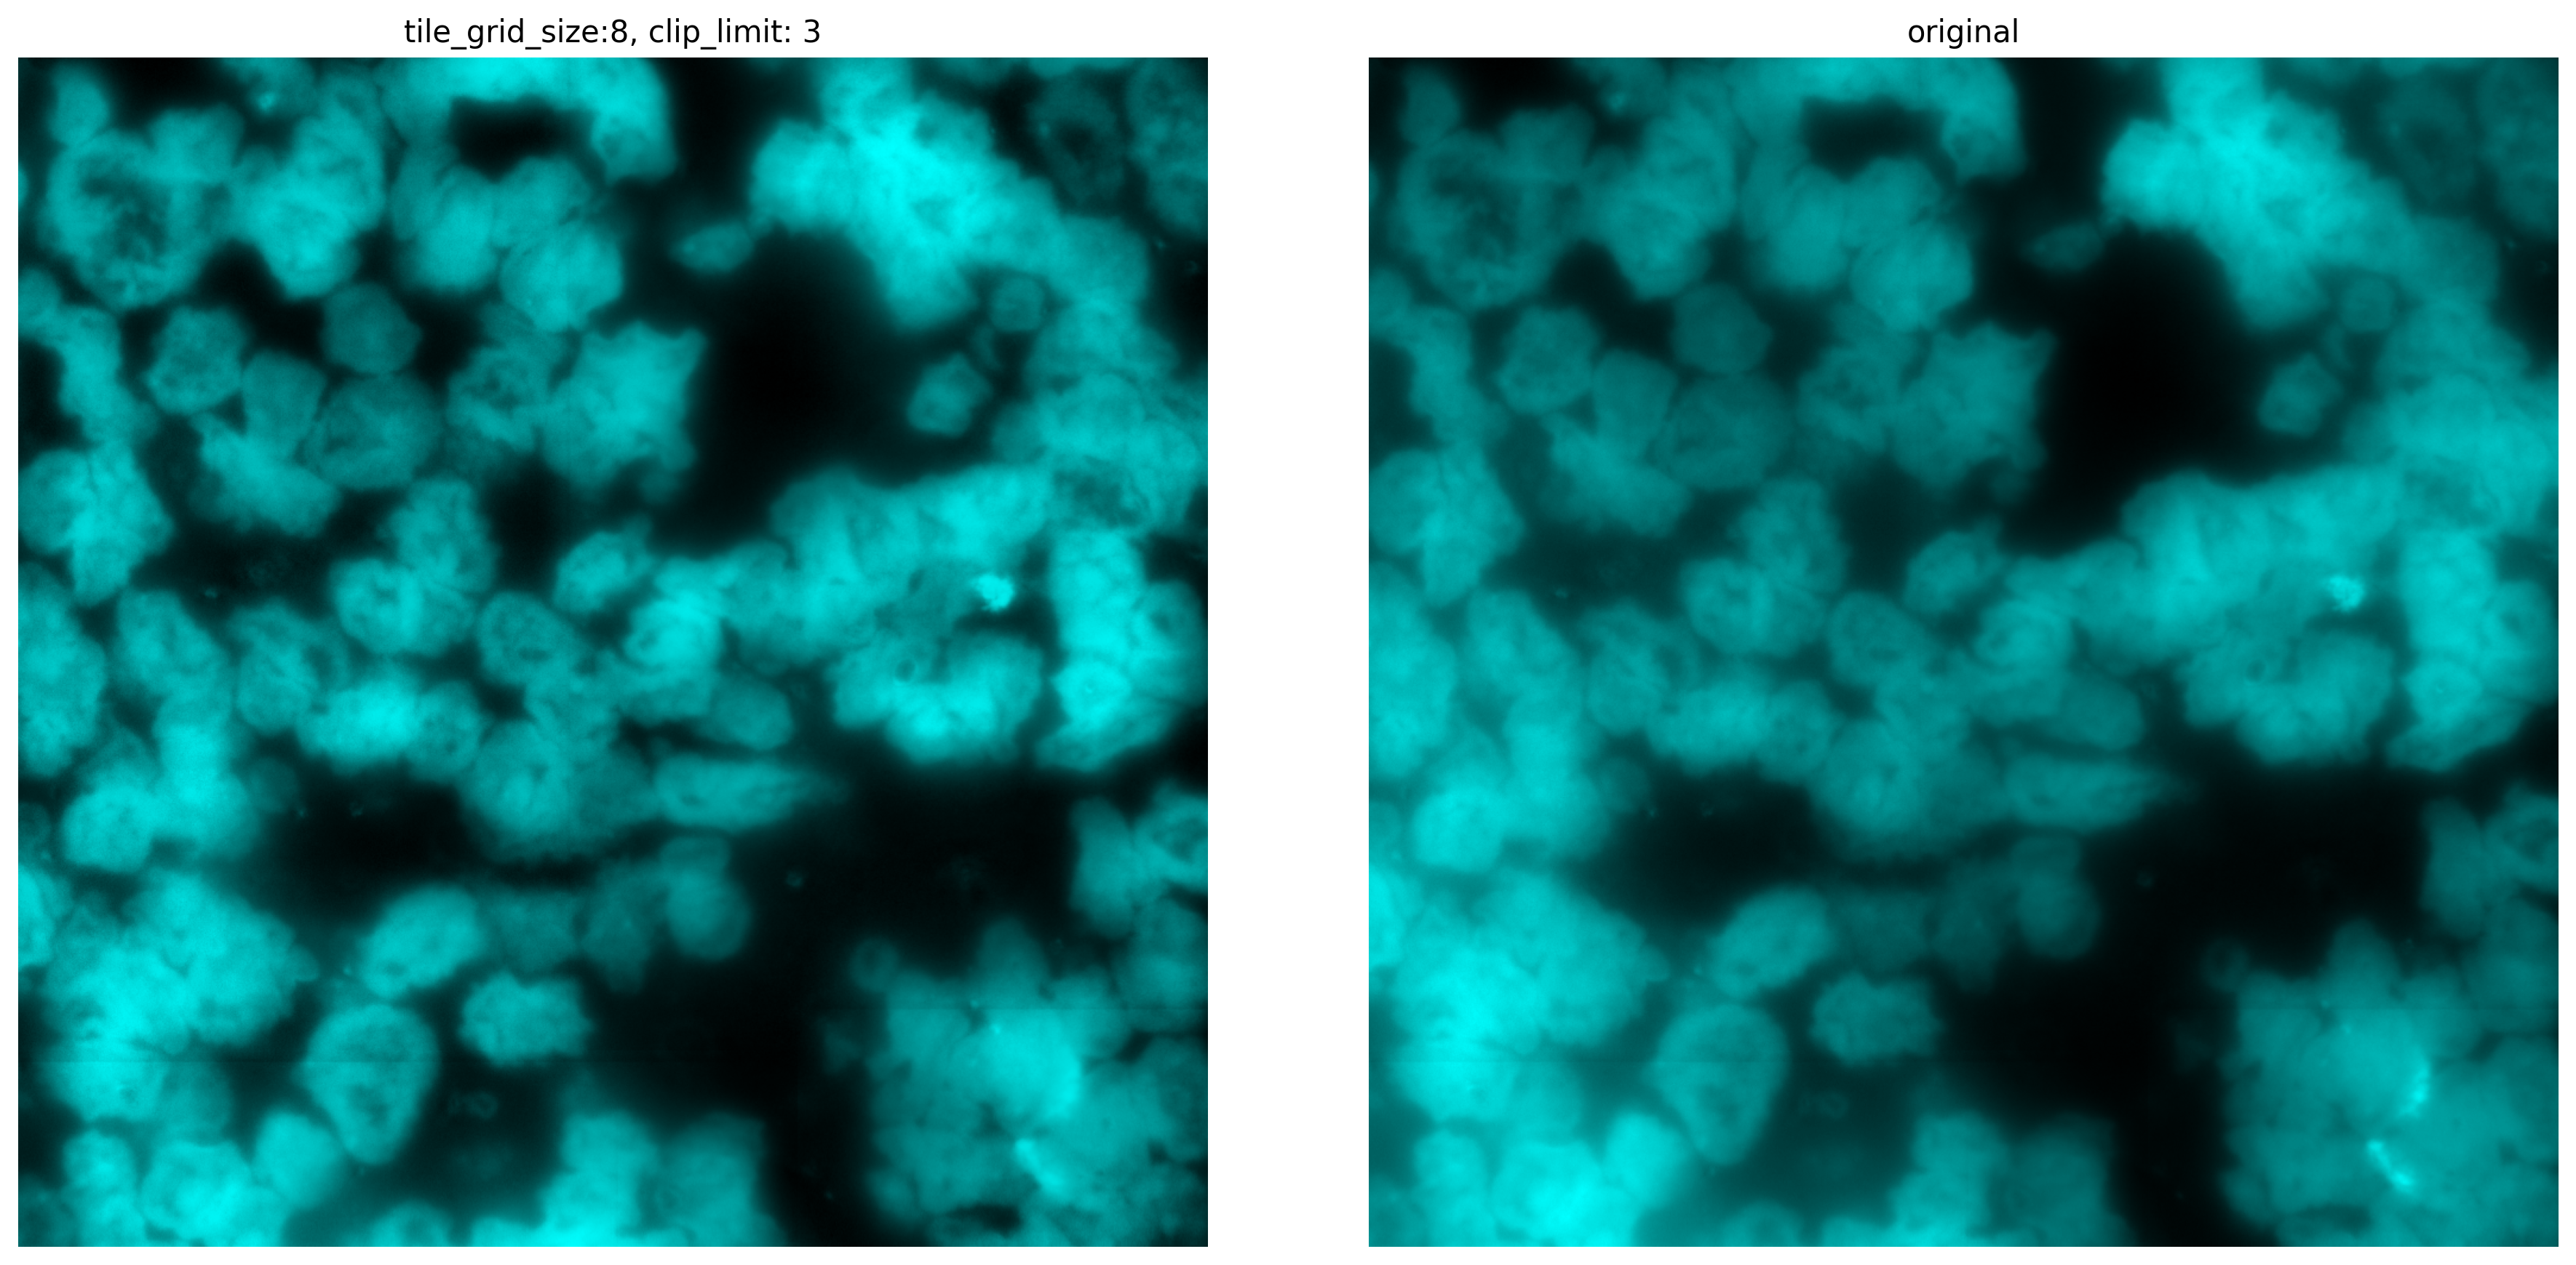

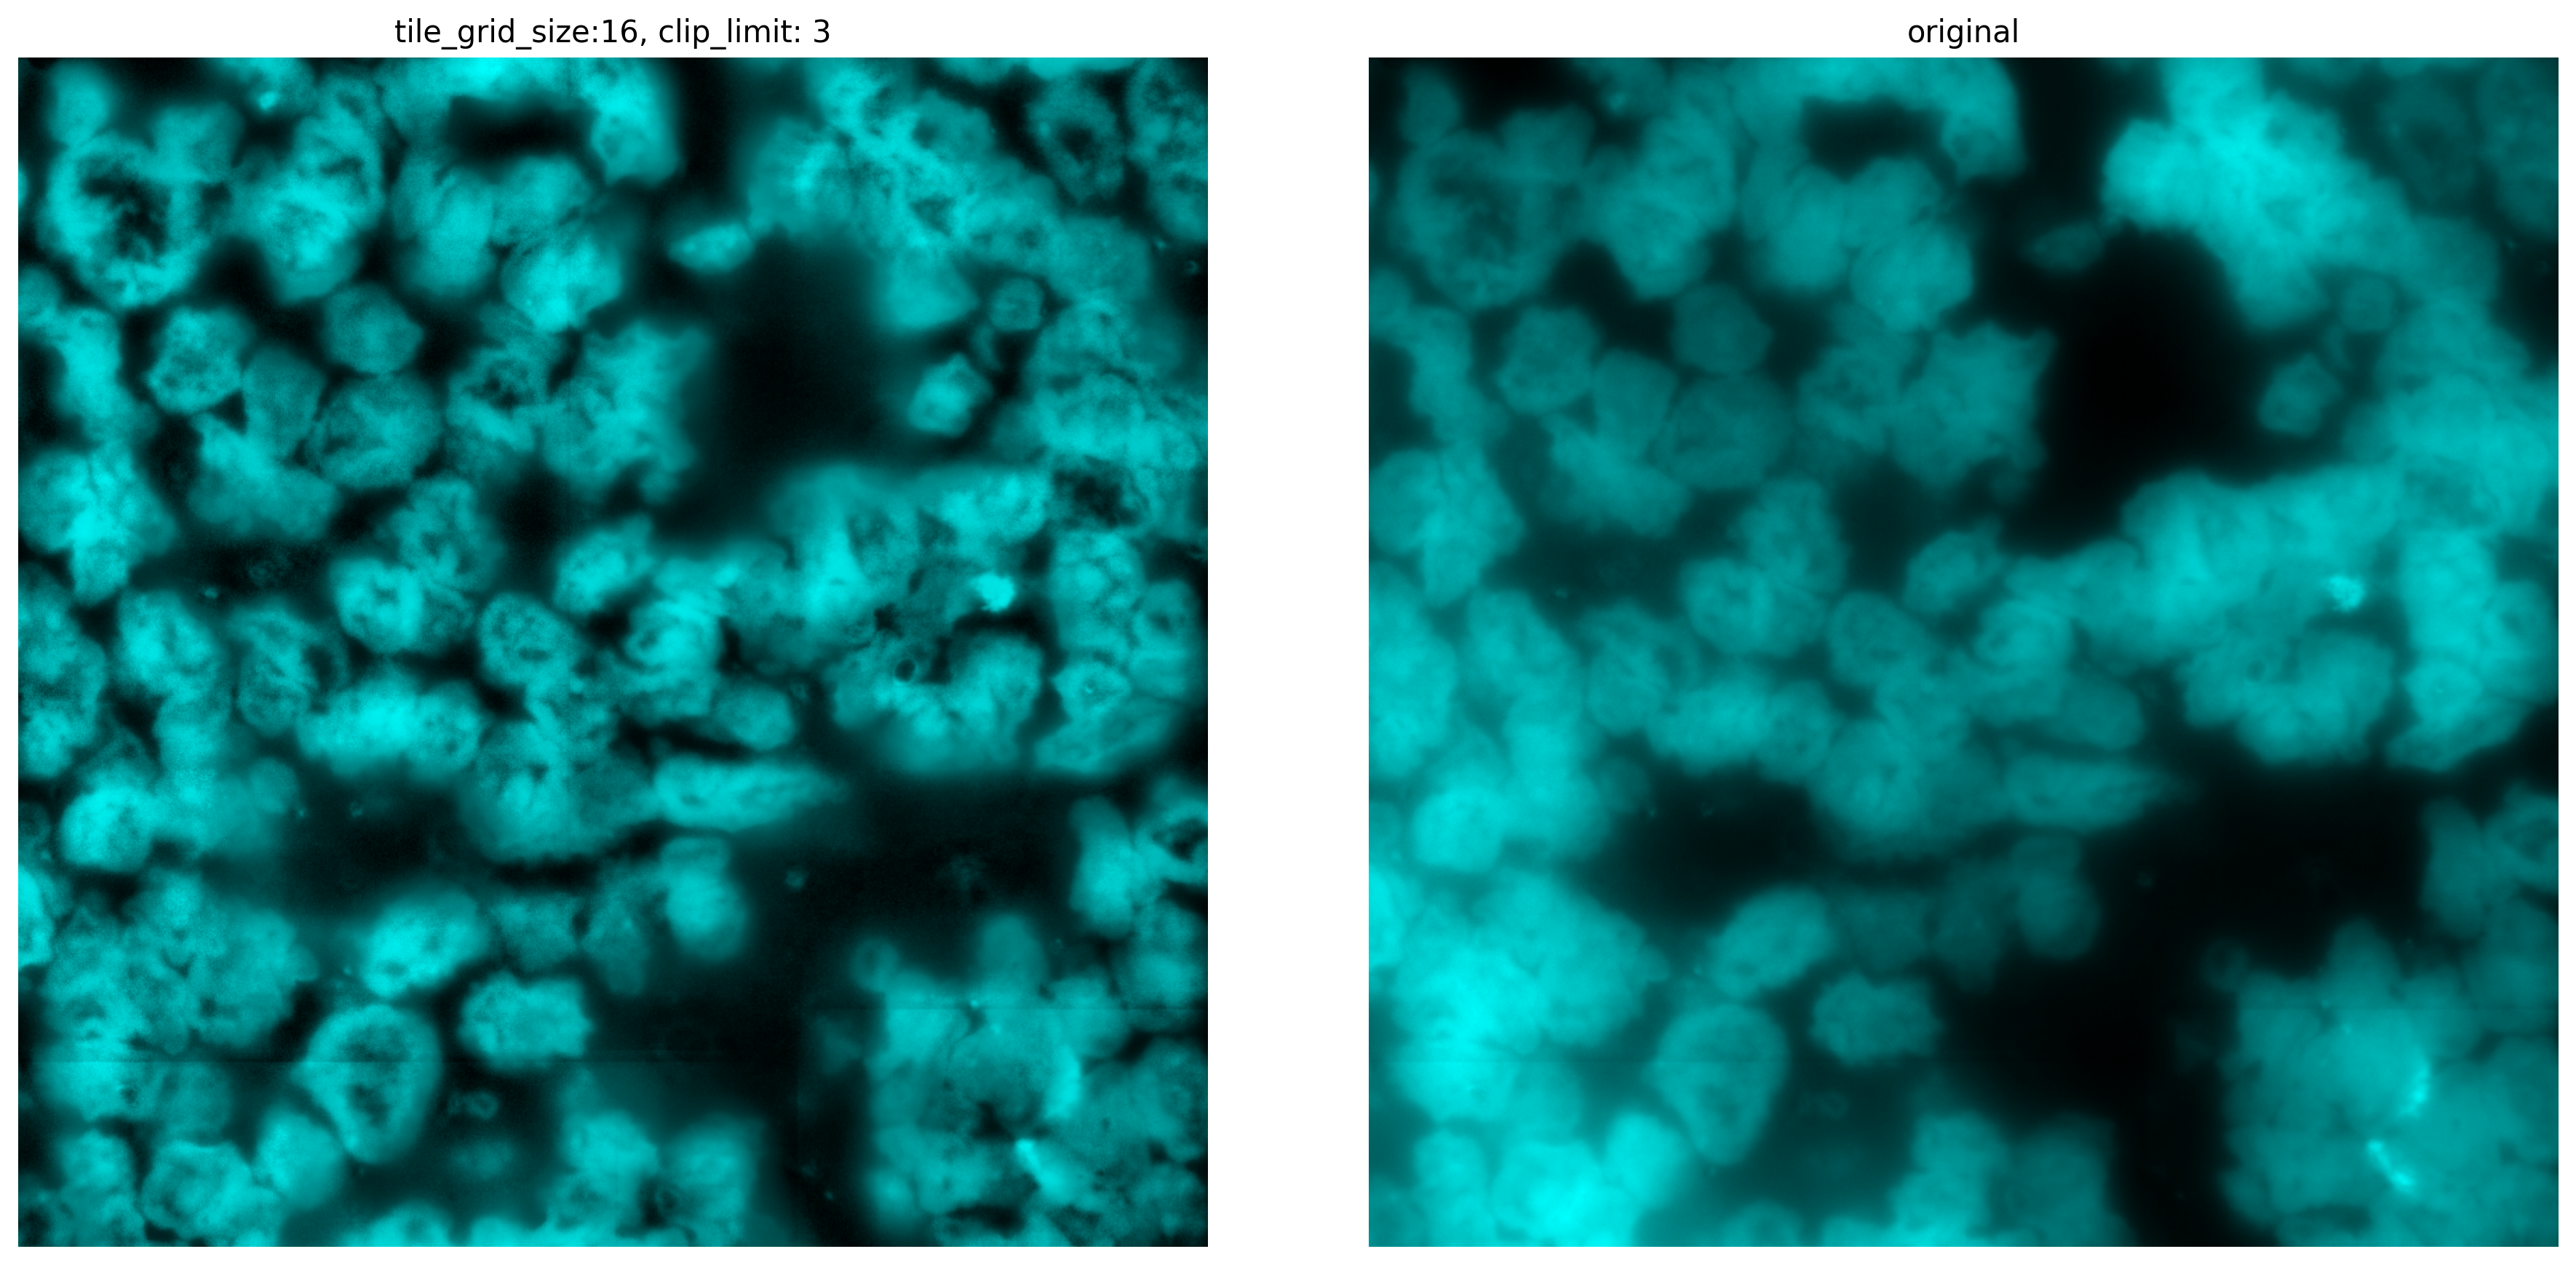

In [43]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pyvips
plt.rcParams['figure.dpi']=250
# Define a custom colormap that transitions from black to blue
black_to_blue = LinearSegmentedColormap.from_list("black_to_blue", ["black", "aqua"])  #aqua

start = 4000
size = 500 #whole core: 2500

method='clahe'

# img_original = np.ascontiguousarray(img[start-size:start+size, start-size:start+size])
# img_8bit = dega.pre.check_and_convert_16_to_8_bit(img_original)
# img_test = img_8bit

# width, height = img_test.shape
# image = pyvips.Image.new_from_memory(img_test, height, width, 1, format="uchar")
# for clahe_tile_size in [25, 32, 64]:
#     for clip in [60]:
#         # Apply CLAHE using hist_local
#         clahe_image = image.hist_local(clahe_tile_size, clahe_tile_size, max_slope=int(clip))
#         clahe_image.write_to_file(f"test.png")
#         img_clahe_test = imread(f"test.png")


#         # Create a figure with 1 row and 2 columns for side-by-side images
#         fig, axes = plt.subplots(1, 2, figsize=(15, 7))

#         # Display img_transformed on the first subplot
#         axes[0].imshow(img_clahe_test, cmap=black_to_blue)
#         axes[0].axis('off')  # Turn off the axis for a cleaner look
#         axes[0].set_title(f"Tile size:{clahe_tile_size}, max_slope: {clip}")


#         # Display img_subset on the second subplot
#         axes[1].imshow(img_original, cmap=black_to_blue)
#         axes[1].axis('off')  # Turn off the axis for a cleaner look
#         axes[1].set_title('original')

#         # Display the figure
#         plt.tight_layout()  # Adjust layout to avoid overlap
#         plt.show()
        


img_original = np.ascontiguousarray(img[start-size:start+size, start-size:start+size])
image = img_original.copy()

width, height = image.shape

for tile_grid_size in [8,16]:
    for clip_limit in [3]:
        # Apply CLAHE using hist_local
        img_clahe_test =  dega.pre.contrast_filter(image, method='clahe', clip_limit=clip_limit, tile_grid_size=(tile_grid_size, tile_grid_size))


        # Create a figure with 1 row and 2 columns for side-by-side images
        fig, axes = plt.subplots(1, 2, figsize=(15, 7))

        # Display img_transformed on the first subplot
        axes[0].imshow(img_clahe_test, cmap=black_to_blue)
        axes[0].axis('off')  # Turn off the axis for a cleaner look
        axes[0].set_title(f"tile_grid_size:{tile_grid_size}, clip_limit: {clip_limit}")


        # Display img_subset on the second subplot
        axes[1].imshow(img_original, cmap=black_to_blue)
        axes[1].axis('off')  # Turn off the axis for a cleaner look
        axes[1].set_title('original')

        # Display the figure
        plt.tight_layout()  # Adjust layout to avoid overlap
        plt.show()
        
        


## Cell Metadata

In [9]:
path_transformation_matrix = f'{data_dir_region}/micron_to_mosaic_pixel_transform.csv'
path_meta_cell_micron = f'{data_dir_region}/cell_metadata.csv'
path_meta_cell_image = f'{path_landscape_files_region}/cell_metadata.parquet'

In [10]:
dega.pre.make_meta_cell_image_coord(
    'MERSCOPE', 
    path_transformation_matrix, 
    path_meta_cell_micron, 
    path_meta_cell_image, 
    image_scale=image_scale
)

## Transcripts

In [11]:
%%time
tile_size = 250 #
path_trx = f'{data_dir_region}/detected_transcripts.csv'
path_trx_tiles = f'{path_landscape_files_region}/transcript_tiles'

tile_bounds = dega.pre.make_trx_tiles(
                'MERSCOPE',
                path_trx,
                path_transformation_matrix,
                path_trx_tiles,
                coarse_tile_size=5000,
                fine_tile_size=tile_size,
                chunk_size=100000,
                verbose=False,
                image_scale=1,
                max_workers=4)
                

tile_bounds


python(47532) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing chunks: 100%|██████████| 15/15 [00:00<00:00, 223.91it/s]
Processing coarse tiles: 231tile [01:05,  3.54tile/s]

CPU times: user 2min 12s, sys: 3min 3s, total: 5min 16s
Wall time: 1min 5s


{'x_min': 435.0, 'x_max': 53836.16, 'y_min': 131.36, 'y_max': 100389.39}

## Cell Boundaries

In [12]:
%%time

path_cell_boundaries = f'{data_dir_region}/cell_boundaries.parquet'
path_meta_cell_micron = f'{data_dir_region}/cell_metadata.csv'
path_transformation_matrix = f'{data_dir_region}/micron_to_mosaic_pixel_transform.csv'
path_output = f'{path_landscape_files_region}/cell_segmentation'

dega.pre.make_cell_boundary_tiles(
    'MERSCOPE',
    path_cell_boundaries,
    path_meta_cell_micron,
    path_transformation_matrix,
    path_output,
    coarse_tile_size=5000,
    fine_tile_size=250,
    tile_bounds=tile_bounds,
    image_scale=1,
    max_workers=8)


Processing coarse tiles: 100%|██████████| 11/11 [02:46<00:00, 15.14s/it]


CPU times: user 3min 9s, sys: 35.2 s, total: 3min 44s
Wall time: 3min 9s


## Gene Metadata

In [18]:
path_cbg = f'{data_dir_region}/cell_by_gene.csv'
path_output = f'{path_landscape_files_region}/meta_gene.parquet'
dega.pre.make_meta_gene(technology, path_cbg, path_output)


cbg is a dense DataFrame. Proceeding with dense operations.
Calculating mean expression
Calculating variance
Calculating maximum expression
Calculating proportion of non-zero expression


In [14]:
cbg = pd.read_csv(path_cbg)
cbg = cbg.set_index('cell')
cbg = cbg.rename_axis('__index_level_0__', axis='columns')
cbg = cbg.astype(pd.SparseDtype("float", fill_value=0))


df_meta = pd.read_parquet(f"{path_landscape_files_region}/cell_metadata.parquet")
entity_to_cell_id_dict = pd.Series(df_meta.index.values, index=df_meta.EntityID).to_dict()

cbg['cell'] = cbg.index.map(entity_to_cell_id_dict)

cbg = cbg.set_index('cell')
display(cbg.head())

dega.pre.save_cbg_gene_parquets(path_landscape_files_region, cbg, verbose=True)

__index_level_0__  PDK4  CD79B  CD9  CD4  TNFRSF17  CEACAM6  LAG3  ESR1  \
cell                                                                      
w6wHcCNCq             0      0    0    0         0        0     0     0   
RDvx4MllU             0      0    0    0         0        0     0     0   
XLdToFTaV             0      0    0  1.0         0        0     0     0   
5kDxZ8TiG             0      0    0    0         0        0     0     0   
iDvhSyThC             0      0    0    0         0        0     0     0   

__index_level_0__  KRT23  CTSG  ...  Blank-21  Blank-22  Blank-23  Blank-24  \
cell                            ...                                           
w6wHcCNCq              0     0  ...         0         0         0         0   
RDvx4MllU              0     0  ...         0         0         0         0   
XLdToFTaV              0     0  ...         0         0         0         0   
5kDxZ8TiG              0     0  ...         0         0         0         0   
iDvhSyThC              0     0  ...         0         0         0         0   

__index_level_0__  Blank-25  Blank-26  Blank-27  Blank-28  Blank-29  Blank-30  
cell                                                                           
w6wHcCNCq                 0         0         0         0         0         0  
RDvx4MllU                 0         0         0         0         0         0  
XLdToFTaV                 0         0         0         0         0         0  
5kDxZ8TiG                 0         0         0         0         0         0  
iDvhSyThC                 0         0         0         0         0         0  

[5 rows x 285 columns]

Processing gene 0: PDK4
Processing gene 100: CD86
Processing gene 200: BANK1


## Get Max Zoom
Save this to a file in the landscape files, read it on the front-end, and use it in the code. 

In [15]:
# Example usage:
path_image_pyramid = f"{path_landscape_files_region}/pyramid_images/dapi_files"  # Change this to your actual directory path
max_pyramid_zoom = dega.pre.get_max_zoom_level(path_image_pyramid)

print(max_pyramid_zoom)

17


## Save Landscape Parameters JSON

In [16]:
image_info =  [
        {
            "name": "dapi",
            "button_name": "DAPI",
            "color": [
                0,
                0,
                255
            ]
        }
    ]

tile_size = 250

In [17]:
dega.pre.save_landscape_parameters(
    technology, 
    path_landscape_files_region,
    'dapi_files',
    tile_size=tile_size,
    image_info=image_info,
    image_format='.webp'
)

/Users/whuan/dev/ist_benchmarking/data/landscapes/2024_merscope_breast_htma/region_0/pyramid_images/dapi_files


In [16]:
des_bucket_name = "fc-secure-cbb15268-8969-436a-818b-ae40f52e3b41/ist_data/landscape_files/"
cmd = f"gsutil -m cp -r {path_landscape_files} gs://{des_bucket_name}"
print (cmd)

gsutil -m cp -r /Users/whuan/dev/ist_benchmarking/data/landscapes/2024_merscope_breast_htma gs://fc-secure-cbb15268-8969-436a-818b-ae40f52e3b41/ist_data/landscape_files/
